# HW3

In [1]:
'''Importing all dependencies'''
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
def rng(m=2**32, a=1103515245, c=12345):
    rng.current = (a * rng.current + c) % m
    return rng.current / m

# setting the seed
rng.current = 1

## Serial test

Idea: break the sequence $x_1, x_2, x_3, ..., x_{2n}$ into consecutive series of length $2$: $(x_1, x_2), (x_3, x_4), ..., (x_{2n-1}, x_{2n})$ and look at each element as a random and independent point in $2D$ space. Next, apply chi-square. Similarly, one can construct series of length $3, 4$, etc.

### Problem 1
Implement serial test and apply to a `samples`

In [2]:
samples = np.array([rng() for _ in range(10000)])
# Your code here
'''=\---------------'''
def serialT(samples, k = 10, dims = 2):
    if len(samples)%dims:
        samples = samples[:-(len(samples)%dims)]
    patrition = lambda sample, d: sample.reshape(-1, dims)
    sampledd = patrition(samples, dims)
    f_obs = np.histogramdd(sampledd, bins = [np.linspace(0,1, k+1) for _ in range(dims)] )[0]
    f_exp = np.full(f_obs.shape, len(sampledd) / (k**dims) , dtype='float64')
    return stats.chisquare(f_obs.flatten(), f_exp.flatten())
serialT(samples, dims = 2), serialT(samples, dims = 3)

(Power_divergenceResult(statistic=87.48, pvalue=0.7895660152477539),
 Power_divergenceResult(statistic=1012.3345334533453, pvalue=0.37755820732038237))

### Permutation test

We again decompose the sequence $x_1, x_2, x_3, ..., x_{dn}$ into consecutive series of length $d$: $(x_1, ..., x_d), (x_{d+1}, x_{2d+d}), \ldots, (x_{nd-d+1}, x_{nd})$. A series of $d$ elements can be ordered in $d!$ ways and each way of ordering is equally probable. Hence the idea of the test is to count how many times each ordering occurs among $n$ series and apply the $\chi^2$ test.

### Problem 2*
Implement permutation test and apply to a `samples`

In [3]:
from itertools import permutations
n = 100
d = 10
rng.current = 1
patrition = lambda sample, d: sample.reshape(sample.shape[0]//d, d)
samplesnd = np.array([rng() for _ in range(n*d)])
samples_d = patrition(samplesnd, d)
# print(samples_d)
def permutationTest(sampls_d, d):
  all_perms = list(permutations(range(d)))
  perm_counts = {perm: 0 for perm in all_perms}
  for sampl in sampls_d:
        sorted_indices = np.argsort(sampl)
        perm = tuple(sorted_indices)
        perm_counts[perm] += 1
  f_obs = np.array(list(perm_counts.values()))
  f_exp = np.full(len(f_obs), len(sampls_d)/ len(all_perms))
  return stats.chisquare(f_obs, f_exp)

permutationTest(samples_d, d)


Power_divergenceResult(statistic=3628700.0000000214, pvalue=0.5145586770496935)

### Problem 3

Provide a statistical test to show that `rng_bad` has problems but `rng_good` does not.

In [4]:
def rng_bad(m=2**31, a=65539, c=0):
    rng_bad.current = (a * rng_bad.current + c) % m
    return rng_bad.current / m
rng_bad.current = 1

random = [rng_bad() for _ in range(30000)]
print("This sequence looks as random:")
random[:10]

This sequence looks as random:


[3.051897510886192e-05,
 0.00018310965970158577,
 0.0008239871822297573,
 0.003295936156064272,
 0.012359732296317816,
 0.04449496837332845,
 0.15573221957311034,
 0.533938602078706,
 0.8020416363142431,
 0.006802399177104235]

#### Solution: Just use serial test with k =30 and dims = 3

In [5]:
# Your code here
samplesGood = np.array([rng() for _ in range(10000)])
samplesBad = np.array([rng_bad() for _ in range(10000)])
print(f"sampleGood p_value = {serialT(samplesGood, k =30, dims =3)[1]}", f"sampleBad p_value ={serialT(samplesBad, k = 30, dims = 3)[1]}")
# print(permutationTest(patrition(samplesGood, d), d), permutationTest(patrition(samplesBad, d), d))

sampleGood p_value = 0.21422815522795674 sampleBad p_value =1.353136897041972e-93


* More randomness tests - [Diehard tests](https://en.wikipedia.org/wiki/Diehard_tests).
* More methods for generating a uniform value [here](https://en.wikipedia.org/wiki/List_of_random_number_generators).
* A story about dynamical systems and the transition to chaos https://www.youtube.com/watch?v=ovJcsL7vyrk&feature=youtu.be

# Generating a sample from a given distribution

Suppose we have a random number generator from the segment [0, 1] (use the `np.random.rand()` function for this). How to get a sample from another distribution $F$?

### Problem 4
Simulate a sample of 1000 from a discrete distribution on a set of digits $0, 1, 2, \ldots, 9$ with weights $0.12, 0.3, 0.167, 0.24, 0.31, 0.54, 0.111, 0.02, 0.001, 0.2$. Construct a histogram from the sample. Optimise the algorithm by ordering the weights.

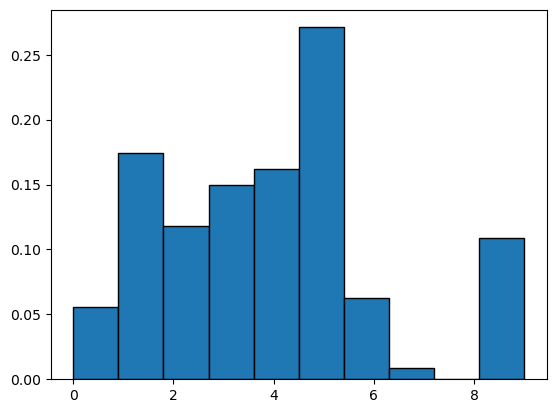

In [6]:
# Your code here
weights = np.array([0.12, 0.3, 0.167, 0.24, 0.31, 0.54, 0.111, 0.02, 0.001, 0.2])
norm_weights = weights/weights.sum()

# Создание кумулятивных весов
cum_weights = np.cumsum(norm_weights)
# print(cumulative_weights)
sample = np.array([np.where(cum_weights > np.random.rand())[0][0] for _ in range(1000)])
fig = plt.figure()
plt.hist(sample, 10, density=True, edgecolor = 'black')
plt.show()


## Inverse transform method

The following proposition is the idea behind the *inverse transform* method:

If $\xi$ has a uniform distribution in $[0,1]$, then $F^{-1}(\xi)$ is distributed according to the law of $F$. (For which $F$ is this true?)

### Problem 5
Simulate a sample of size 1000 from the distribution $\operatorname{Exp}(\lambda)$ using the Inverse transform method. Construct a sample histogram and an accurate plot of the distribution density.

#### Solution

$$ \xi = F_{Exp(\lambda)}(x) =  \begin{cases}
1 - e^{-\lambda x}, & x \geq 0, \\
0, & x < 0.
\end{cases}$$
Therefore:
$$x = -\frac{ln(1-\xi)}{\lambda} $$

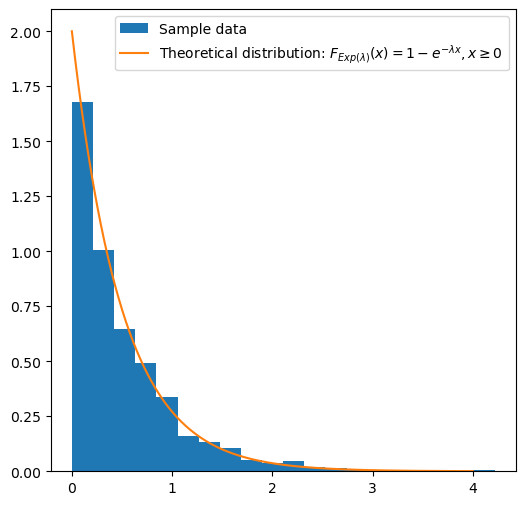

In [7]:
# Your code here
from scipy.stats import expon
lamda = 2
sample = np.array([-np.log(1-np.random.rand())/lamda for _ in range(1000)])
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
line2 = ax.hist(sample, 20, density=True, label ='Sample data')
x = np.linspace(0, 4, 1000)
line1 = ax.plot(x, expon.pdf(x, scale = 1/lamda), label = r'Theoretical distribution: $F_{Exp(\lambda)}(x) = 1 - e^{-\lambda x},  x \geq 0$')
ax.legend(loc='upper right')
None

## Rejection sampling (Accept-reject method)

The idea of the method is to sample from the distribution we know how to sample from, and then select points that follow the desired distribution. More precisely: let's say we know how to sample from a distribution with density $p$, and we want to sample from a distribution with density $\pi$. Let's take a random $x$ from the distribution $p$. Then take $y$ uniformly distributed on the interval $[0, p(x)]$. If the point $(x, y)$ falls under the graph of $\pi$, we take $x$ as a sampling element from $\pi$. If not, we repeat the procedure for a new $x$. The picture illustrates the idea of the method (the densities are normalised so that one lies entirely under the other):

<img src=https://colcarroll.github.io/hamiltonian_monte_carlo_talk/images/bayes_talk.015.png style="width: 50%;"/>

### Problem 6
Justify (orally) that the accept-reject method really samples from the required distribution. Simulate $1000$ points from the distribution with density $e^xcos^2x \cdot \mathbb{I}_{[-\frac\pi2, \frac\pi2]}$. Plot the sampled histogram on the sample and compare it with the plot of the exact density function.

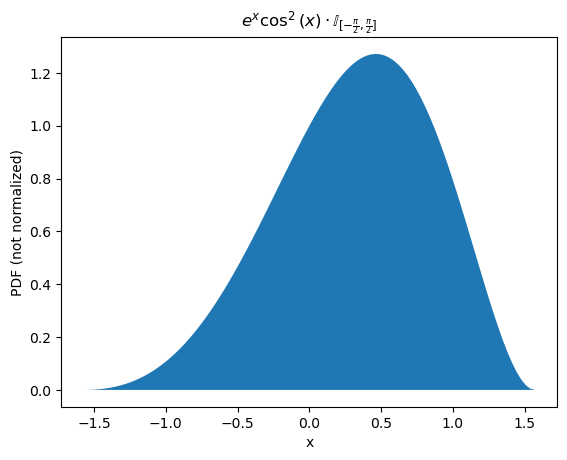

In [8]:
fig = plt.figure()

x = np.linspace(-np.pi/2, np.pi/2, 100)
density = np.exp(x) * np.cos(x) ** 2 # not normalized density!
plt.fill_between(x, 0, density)
plt.ylabel('PDF (not normalized)')
plt.xlabel('x')
plt.title(r'$e^x \cos^2(x) \cdot \mathbb{I}_{[-\frac{\pi}{2}, \frac{\pi}{2}]}$')

plt.show()

#### Solution

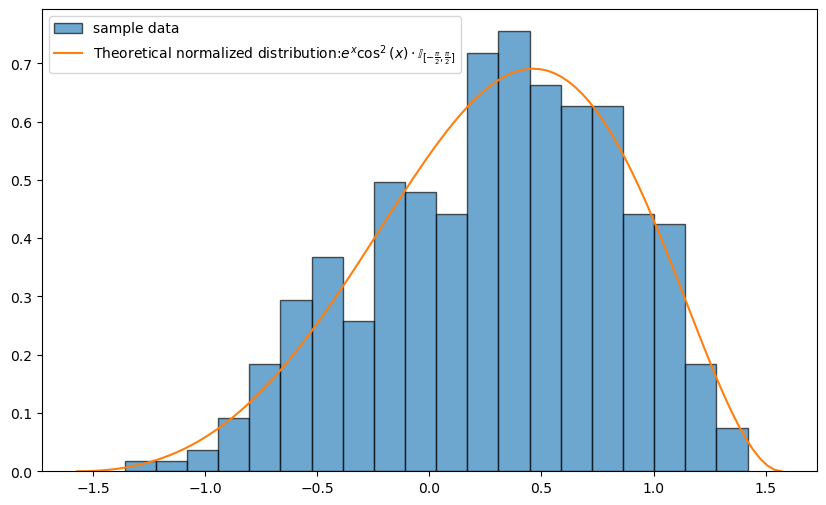

In [26]:
# Your code here
N = 1000
x = np.linspace(-np.pi/2, np.pi/2, 100)
density = np.exp(x) * np.cos(x) ** 2 # not normalized density!
x_start, x_end = -np.pi/2, np.pi/2
y_start, y_end =0, 1.5
normalizer = np.trapz(density, x)
square_sample = np.array([[np.random.rand()*(x_end-x_start) +x_start, np.random.rand()*(y_end-y_start)+y_start] for _ in range(N)])
dens_sample = np.array([[x, y] for x,y in square_sample if (np.exp(x) * np.cos(x) ** 2) > y])
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
line1 = ax.hist(dens_sample[:,0].ravel(), bins = 20, density = True, edgecolor = 'black', alpha = 0.65, label = 'sample data')
line2 = ax.plot(x, (np.exp(x) * np.cos(x) ** 2)/normalizer, label = r'Theoretical normalized distribution:$e^x \cos^2(x) \cdot \mathbb{I}_{[-\frac{\pi}{2}, \frac{\pi}{2}]}$' )
ax.legend(loc = 'upper left')
None

## Coordinate transformation method

The accept-reject method may in some cases be inefficient and require too many sample points. An alternative is to try to find a coordinate transformation that converts a simple area (from which it is easy to sample, for example, a unit square) into the required area, but preserves the area ratio (why?).

### Problem 7
Model and depict a sample of 500 points uniformly distributed within a given triangle without using a selection method.

#### Solution:

##### Step 1: Generate a sample in straight triangle ((0,0), (0,1), (1,0)):

To generate a point (u,v):
* Generate uniformly (r1, r2) in [0,1]x[0,1] square.
* if $r_{1}+r_{2}\le1$, then: $u =r_{1}; \ v = r_{2} $
* else: reflect across $u + v = 1$ by setting $u = 1-r_{1}; \ v = 1-r_{2}$
<!-- $$x = (1-\sqrt{u})\cdot x_{1}+(\sqrt{u} \cdot (1-v))\cdot x_{2} + (\sqrt{u}\cdot v )\cdot x_{3}$$
$$y = (1-\sqrt{u})\cdot y_{1}+(\sqrt{u} \cdot (1-v))\cdot y_{2} + (\sqrt{u}\cdot v )\cdot y_{3}$$ -->

##### Step2: Perform affine tranformation of straight triangle to given triangle((x1,y1), (x2,y2), (x3, y3))
$$x = x_{1}+(x_{2}-x_{1})\cdot u + (x_{3}-x_{1})\cdot v$$
$$y = y_{1}+(y_{2}-y_{1})\cdot u + (y_{3}-y_{1})\cdot v$$

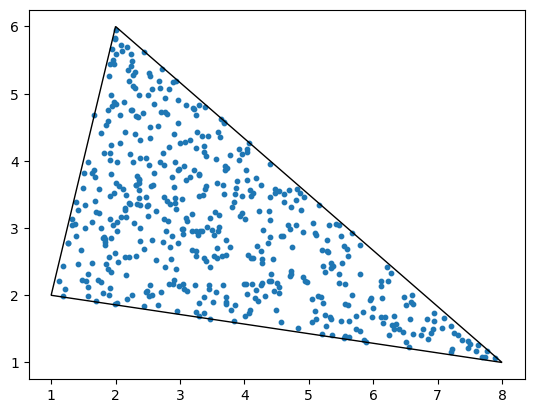

In [27]:
# Your code here

N = 500
x1, y1 = 1, 2
x2, y2 = 2, 6
x3, y3 = 8, 1
trX = lambda u, v, x1, x2, x3: x1+(x2-x1)*u+(x3-x1)*v
trY = lambda u, v, y1, y2, y3: y1+(y2-y1)*u+(y3-y1)*v
def genStraightTriangleSample():
    r1, r2 = np.random.rand(), np.random.rand()
    if r1+r2>1:
        return [1-r1, 1-r2]
    return [r1, r2]
unit_sample = np.array([genStraightTriangleSample() for _ in range(N)])
# unit_sample
triangle_sample = np.array([[trX(point[0], point[1], x1, x2, x3), trY(point[0], point[1], y1, y2, y3)] for point in unit_sample])
fig, ax = plt.subplots()
ax.scatter(triangle_sample[:, 0], triangle_sample[:, 1], s = 10)
vertices = np.array([[1, 2], [2,6], [8, 1]])
triangle = Polygon(vertices, closed=True, edgecolor='black', facecolor='none')
ax.add_patch(triangle)
None


### Problem 8
Model without using the selection method a sample of $500$ points uniformly distributed inside the unit circle. Picture the obtained points. Do they really fill the circle uniformly?

#### Solution:
* Generate angle uniformly from [0, 2$\pi$]
* Generate radius from $\sqrt{U[0, 1]}$

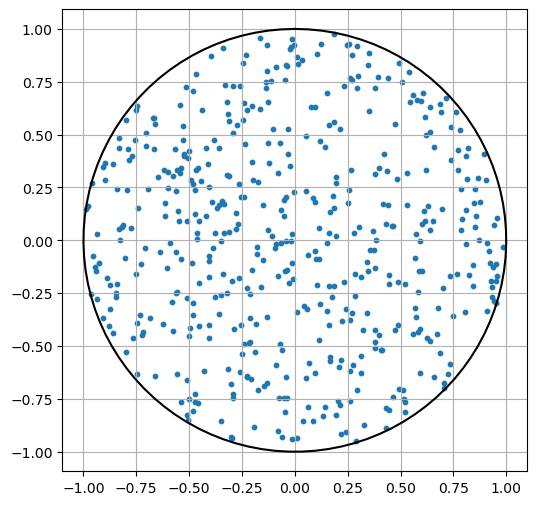

In [28]:
# Your code 
N = 500
theta_sample = np.array([np.random.rand()*2*np.pi for _ in range(N)])
r_sample = np.array([np.sqrt(np.random.rand()) for _ in range(N)])
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(r_sample*np.cos(theta_sample), r_sample*np.sin(theta_sample), s =10)
t = np.linspace(0, 2*np.pi, 100)
ax.plot(np.sin(t), np.cos(t), color ='black')
ax.axis('equal')
# plt.show()
ax.grid()


##### Let's check if they're really uniformply distributed by density scatter plot but with a larger sample(N = 5000):

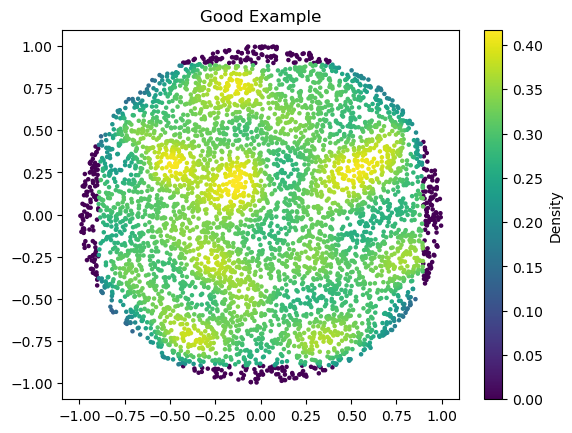

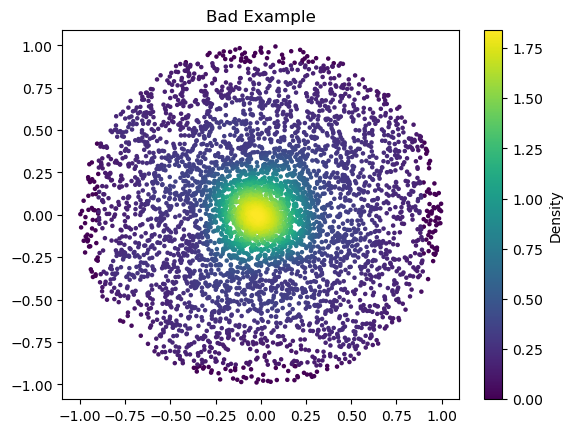

In [29]:
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn


def density_scatter( x , y, ax = None, sort = True, bins = 20, title = 'default', **kwargs )   :
    """
    Scatter plot colored by 2d histogram 'function was taken from:
    https://stackoverflow.com/questions/20105364/how-can-i-make-a-scatter-plot-colored-by-density/53865762#53865762'
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z, **kwargs , s = 5)

    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax)
    cbar.ax.set_ylabel('Density')
    ax.set_title(title)

    return ax
N = 5000
theta_sample = np.array([np.random.rand()*2*np.pi for _ in range(N)])
r_sample = np.array([np.sqrt(np.random.rand()) for _ in range(N)])
r_bad_sample = np.array([(np.random.rand()) for _ in range(N)])
density_scatter( r_sample*np.cos(theta_sample), r_sample*np.sin(theta_sample), bins = [10,10], title ='Good Example' )
density_scatter( r_bad_sample*np.cos(theta_sample), r_bad_sample*np.sin(theta_sample), bins = [10,10], title = 'Bad Example' )
None

# Random normal generator

### Problem 9
Prove (orally) that the following algorithm (**Box-Muller algorithm**, https://en.wikipedia.org/wiki/Box%E2%80%93Muller_transform) generates a sample of independent $\mathcal{N}(0,1)$ random variables. Modify the method to exclude calls of trigonometric functions `np.sin` and `np.cos`. Using the modified method, simulate a sample size of $1000$ from a $2D$ Gaussian distribution with mean $\mu$ and covariance matrix $\Sigma$, where
$$\mu = \begin{pmatrix} 4 \\ 7 \end{pmatrix}^T, \quad \Sigma = \begin{pmatrix} 20 & -4 \\ -4 & 40 \end{pmatrix}.$$
Construct a 2D histogram of the resulting distribution. Compare the sample mean and covariance matrix with the exact values.

In [30]:
import seaborn as sns

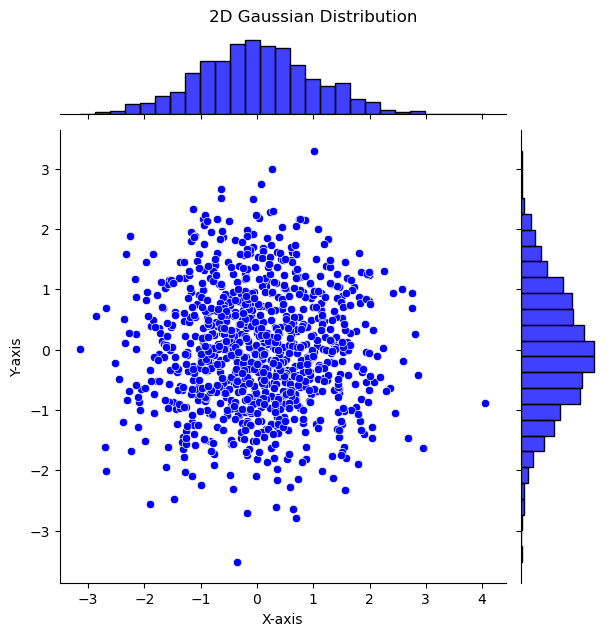

In [31]:
n = 1000
u1, u2 = np.random.rand(2, n)
r = np.sqrt(-2 * np.log(u1))
theta = 2 * np.pi * u2
x = r * np.cos(theta)
y = r * np.sin(theta)


joint_plot = sns.jointplot(x=x, y=y, color="blue")
joint_plot.set_axis_labels('X-axis', 'Y-axis')
plt.suptitle('2D Gaussian Distribution', y=1.02)
plt.show()

#### Solution:


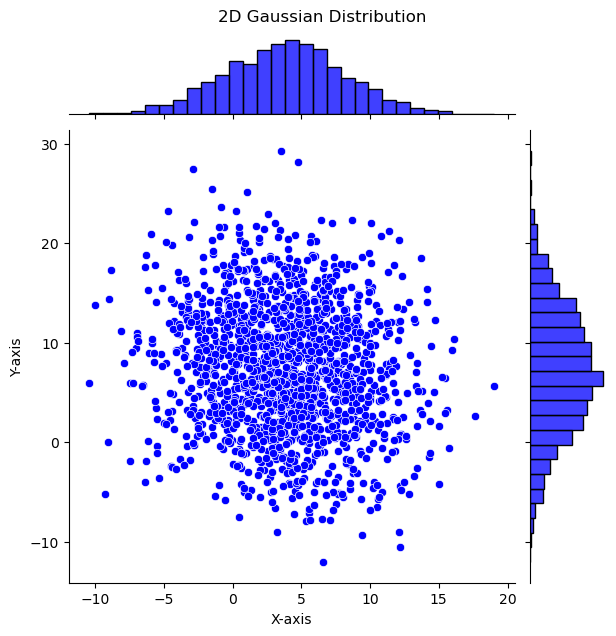

Theoretical mean = [4 7], Expiremental mean =  [3.81 7.26]
Theoretical cov = [[20 -4]
 [-4 40]]
Expiremental cov =  [[20.02 -3.56]
 [-3.56 39.67]]


In [32]:
# Your code here
n = 2000
u1, u2 = [np.random.rand()*2-1 for _ in range(n)], [np.random.rand()*2-1 for _ in range(n)]
exp = np.array([4, 7])
std = np.array([[20, -4], [-4, 40]])

# Cholesky decomposition
L = np.linalg.cholesky(std)
samples = []
for x, y in zip(u1, u2):
    if x**2+y**2<=1 and x**2+y**2>0:
        samples.append([x, y])
samples = np.array(samples)
# print(samples.shape)

u, v = samples[:,0], samples[:,1]
s = np.sum(samples**2, axis = 1)
# print(samples[:2], s[:2])

z0 = u*np.sqrt(-2*np.log(s)/s) 
z1 = v*np.sqrt(-2*np.log(s)/s) 

Z = np.hstack((z0.reshape(-1, 1), z1.reshape(-1, 1)))
newZ = exp.reshape(-1, 1)+L@Z.T
# print(newZ.shape)

joint_plot = sns.jointplot(x=newZ[0, ], y=newZ[1,: ], color="blue")
joint_plot.set_axis_labels('X-axis', 'Y-axis')
plt.suptitle('2D Gaussian Distribution', y=1.02)
plt.show()

z_mean = np.mean(newZ, axis = 1)
print(f"Theoretical mean = {exp}, Expiremental mean =  {np.round(z_mean, 2)}")
print(f"Theoretical cov = {std}", f"Expiremental cov =  {np.round(np.cov(newZ), 2)}", sep ="\n")

### Problem 10*

Implement a method of generating a random partition of an n-element set into subsets. Use it to estimate the expected number of subsets in a random partition of a set of 100 elements.

Hint 1: Ширяев, Вероятность, т1, задача 2 к параграфу 1.

Hint 2: http://djalil.chafai.net/blog/2012/05/03/generating-uniform-random-partitions/

In [33]:
# Your code here
%time
import scipy.special
from functools import lru_cache
n = 100
@lru_cache(maxsize = n+1)
def Bn(n = 0):
    if n == 0:
        return 1
    else:
        S = 0
        for i in range(0, n):
            S+=scipy.special.binom(n-1, i)*Bn(i)
        return S

def invers_transfK( u , n):
    cumProb = 0
    k = 1 
    B_n = Bn(n)
    while True:
        cumProb += (k**n)/(scipy.special.factorial(k)*np.exp(1)*B_n)
        if cumProb >=u:
            return k
        k+=1

def randPatrition(n):
    'returns patrition, numbers of subsets'
    K = invers_transfK(np.random.rand(), n)
    weights = np.array([1/K for _ in range(K)])
    a = list(range(1, n+1))
    cum_weights = np.cumsum(weights)
    sample = np.array([np.where(cum_weights > np.random.rand())[0][0] for _ in range(n)])+1
    hash_ptr = {c: [] for c in sample}
    # print(sample)
    for i, c in enumerate(sample):
        hash_ptr[c].append(a[i])
    freq = np.array([[i, np.count_nonzero(sample==i)] for i in range(1, K+1)])
    return hash_ptr, len(np.unique(sample))
ptr, length = randPatrition(n)
print("Patrition of {1, ... , 100}: ", "{", *ptr.values(), "}", sep ="")
N = 100
expNumSub = np.array([randPatrition(n)[1] for _ in range(N)]).mean()
print(f'Math Expectation = {expNumSub}')
# print(freq)


CPU times: user 4 μs, sys: 0 ns, total: 4 μs
Wall time: 7.87 μs
Patrition of {1, ... , 100}: {[1, 28, 34][2, 84, 85][3, 5, 19, 67, 68][4, 17, 22, 32, 80, 95][6, 82, 83][7, 81, 99][8, 12, 20, 54, 61, 78][9, 16, 48, 87, 98][10, 94][11, 29, 33, 42, 71][13, 64, 75, 77][14, 62, 65, 79][15, 27, 40, 89, 93][18, 21, 53, 63, 73, 88, 92][23, 37, 57][24, 36, 56][25, 45][26, 30, 44, 59, 76, 86, 91][31][35, 52, 69][38, 46, 60][39][41, 43, 58, 72, 74, 96][47][49][50, 97][51, 66][55, 70, 90][100]}
Math Expectation = 28.43
